# Jupiter's Notebook for Scenario 01
Requieres: [CategoryEncoders](http://contrib.scikit-learn.org/category_encoders/), [imbalanced-learn](https://imbalanced-learn.org/stable/), [XGBoost](https://pypi.org/project/xgboost/), and [dill](https://pypi.org/project/dill/)<br>
`pip install category_encoders`<br>
`pip install imbalanced-learn`<br>
`pip install xgboost`<br>
`pip install dill`

In [2]:
#import libraries
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
#To identify class 0 and 1, respectively
target_names = ['class 0', 'class 1']

In [4]:
#load dataset
df=pd.read_csv('esc-01-Mixed-traffic.csv')

In [5]:
#No trunkated 
pd.set_option('display.max_columns', None)

In [6]:
#Dataset dimensions, number of sessions and features
df.shape

(310663, 52)

In [7]:
#counting classes
collections.Counter(df.label.values)

Counter({0: 292386, 1: 18277})

In [8]:
#check the number of null values
print(df.isnull().sum())
print(df.isnull().values.sum())

proto                 0
ts                    0
srcIP                 0
srcPrt                0
dstIP                 0
dstPrt                0
flowduration          0
total_fpackets        0
total_bpackets        0
total_fpktl           0
total_bpktl           0
min_fpktl             0
min_bpktl             0
max_fpktl             0
max_bpktl             0
mean_fpktl            0
mean_bpktl            0
std_fpktl             0
std_bpktl             0
total_fipt            0
total_bipt            0
min_fipt              0
min_bipt              0
max_fipt              0
max_bipt              0
mean_fipt             0
mean_bipt             0
std_fipt              0
std_bipt              0
fpsh_cnt              0
bpsh_cnt              0
furg_cnt              0
burg_cnt              0
total_fhlen           0
total_bhlen           0
fPktsPerSecond        0
bPktsPerSecond        0
flowPktsPerSecond     0
flowBytesPerSecond    0
mean_flowpktl         0
std_flowpktl          0
mean_flowipt    

In [9]:
#Dropping Rows with NA inplace
df.dropna(inplace=True)

In [10]:
#sumarize the number of unique values for each column 
print(df.nunique())

proto                      2
ts                    310663
srcIP                  12361
srcPrt                 52788
dstIP                  13632
dstPrt                   340
flowduration          187149
total_fpackets           703
total_bpackets           922
total_fpktl             9883
total_bpktl            22973
min_fpktl                149
min_bpktl                495
max_fpktl               1333
max_bpktl               1142
mean_fpktl             21622
mean_bpktl             27875
std_fpktl              38638
std_bpktl              35450
total_fipt            110017
total_bipt             89339
min_fipt               53908
min_bipt               31118
max_fipt              106490
max_bipt               80321
mean_fipt             104800
mean_bipt              86597
std_fipt               86574
std_bipt               74955
fpsh_cnt                 173
bpsh_cnt                 440
furg_cnt                   1
burg_cnt                   1
total_fhlen             3413
total_bhlen   

In [11]:
# Delete time stamp (ts), srcIP and dstIP features
# Models do not learn with IP addresses
df.drop(['ts','srcIP','dstIP'],axis=1,inplace=True)

In [12]:
#Dataset dimensions, number of sessions and features
print(df.shape)

(310663, 49)


In [13]:
#Delete Rows That Contain Duplicate Data
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(310663, 49)
(307754, 49)


In [14]:
df

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio,label
0,TCP,41039,25,0.000012,1,1,62,54,62,54,62,54,62.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,28,20,83886.078125,83886.078125,167772.156250,9.730785e+06,58.000000,5.656854,0.000012,0.000000,0,1,1,1,0,0,0,0.870968,0
1,TCP,41040,25,0.000012,1,1,62,54,62,54,62,54,62.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,28,20,83886.078125,83886.078125,167772.156250,9.730785e+06,58.000000,5.656854,0.000012,0.000000,0,1,1,1,0,0,0,0.870968,0
2,TCP,60720,80,0.000021,1,1,60,54,60,54,60,54,60.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,20,20,47662.546875,47662.546875,95325.093750,5.433530e+06,57.000000,4.242640,0.000021,0.000000,1,0,0,2,0,0,0,0.900000,0
3,TCP,60731,80,55.912911,21,35,1632,43821,60,54,426,1434,77.714287,1252.028564,79.812993,459.122215,55.912897,55.912895,0.006430,0.000005,50.871063,50.879055,2.795645,1.644497,11.363543,8.740217,1,11,0,0,432,712,0.375584,0.625973,1.001558,8.129249e+02,811.660714,679.490845,1.101565,6.891815,2,2,0,55,0,0,0,26.851103,0
4,TCP,48889,80,12.624237,5,5,788,735,66,66,516,459,157.600006,147.000000,200.381636,174.490687,12.624228,12.624222,0.000705,0.001572,12.213220,12.211629,3.156057,3.156055,6.038878,6.037814,1,1,0,0,168,172,0.396064,0.396064,0.792127,1.206410e+02,152.300000,177.225571,2.737010,5.315071,2,2,0,9,0,0,0,0.932741,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310658,UDP,58665,53,0.259362,1,1,73,382,73,382,73,382,73.000000,382.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,39,348,3.855615,3.855615,7.711230,1.754305e+03,227.500000,218.496002,0.259362,0.000000,0,0,0,0,0,0,0,5.232877,0
310659,UDP,47777,53,0.076347,1,1,84,324,84,324,84,324,84.000000,324.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,50,290,13.098072,13.098072,26.196144,5.344014e+03,204.000000,169.705627,0.076347,0.000000,0,0,0,0,0,0,0,3.857143,0
310660,UDP,62559,53,0.000184,1,1,84,143,84,143,84,143,84.000000,143.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,50,109,5433.036133,5433.036133,10866.072266,1.233299e+06,113.500000,41.719299,0.000184,0.000000,0,0,0,0,0,0,0,1.702381,0
310661,UDP,47777,53,0.107837,1,1,100,129,100,129,100,129,100.000000,129.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,66,95,9.273258,9.273258,18.546516,2.123576e+03,114.500000,20.506096,0.107837,0.000000,0,0,0,0,0,0,0,1.290000,0


In [15]:
#check % class distribution 
y=df['label'].values #convert to nparray

classes=np.unique(y)
total=len(y)

for c in classes:
    n_examples=len(y[y==c])
    percent = n_examples/total*100
    print('> Class %d : %d of %d (%.1f%%)' % (c, n_examples,total,percent))

> Class 0 : 289490 of 307754 (94.1%)
> Class 1 : 18264 of 307754 (5.9%)


# Create training and test dataset

In [16]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=42)

In [17]:
#Original dataset dimensions
X_train.shape, X_test.shape

((246203, 48), (61551, 48))

# Coding of categorical variables
[Target encoding](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) for categorical features will be used to encode three nominal categorical variables: protocol, source and destination ports. This method is supervised and requires training.

In [18]:
#load library for target encoder 
from category_encoders import TargetEncoder

In [19]:
#check data types for each feature
df.dtypes

proto                  object
srcPrt                  int64
dstPrt                  int64
flowduration          float64
total_fpackets          int64
total_bpackets          int64
total_fpktl             int64
total_bpktl             int64
min_fpktl               int64
min_bpktl               int64
max_fpktl               int64
max_bpktl               int64
mean_fpktl            float64
mean_bpktl            float64
std_fpktl             float64
std_bpktl             float64
total_fipt            float64
total_bipt            float64
min_fipt              float64
min_bipt              float64
max_fipt              float64
max_bipt              float64
mean_fipt             float64
mean_bipt             float64
std_fipt              float64
std_bipt              float64
fpsh_cnt                int64
bpsh_cnt                int64
furg_cnt                int64
burg_cnt                int64
total_fhlen             int64
total_bhlen             int64
fPktsPerSecond        float64
bPktsPerSe

In [20]:
# Selecting the three categorical variables to be coded
enc = TargetEncoder(cols=['proto','srcPrt','dstPrt'])
# fit on the trainning dataset
enc.fit_transform(X_train, y_train)
# Coding categorical variables of the trainning dataset
training_numeric_dataset=enc.transform(X_train)
# Coding categorical variables of the test dataset
testing_numeric_dataset = enc.transform(X_test)

In [21]:
#show trainning dataset
training_numeric_dataset

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
214710,0.025356,0.000000,0.025093,181.908309,7,7,533,1086,72,120,86,216,76.14286,155.142853,4.913538,30.262345,181.726792,181.723170,0.000057,0.000018,87.210060,87.210007,30.287798,30.287195,43.597218,43.596474,0,0,0,0,295,848,0.038481,0.038481,0.076962,8.900088e+00,115.642857,45.979271,14.064630,32.192545,0,0,0,0,0,0,0,2.037524
85870,0.025356,0.001066,0.025093,14.980404,1,1,68,68,68,68,68,68,68.00000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,34,34,0.066754,0.066754,0.133508,9.078526e+00,68.000000,0.000000,14.980404,0.000000,0,0,0,0,0,0,0,1.000000
257863,0.025356,0.000000,0.025093,0.077758,1,1,91,305,91,305,91,305,91.00000,305.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,57,271,12.860401,12.860401,25.720802,5.092719e+03,198.000000,151.320847,0.077758,0.000000,0,0,0,0,0,0,0,3.351648
252154,0.025356,0.333333,0.025093,0.000310,1,1,77,169,77,169,77,169,77.00000,169.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,43,135,3226.387695,3226.387695,6452.775391,7.936914e+05,123.000000,65.053825,0.000310,0.000000,0,0,0,0,0,0,0,2.194805
10867,0.167577,0.153846,0.021653,5.899355,8,10,993,8622,60,54,571,1434,124.12500,862.200012,180.566124,696.695975,5.899345,5.899335,0.011698,0.000009,4.927249,4.945889,0.842763,0.655482,1.817853,1.626900,1,2,0,0,168,208,1.356080,1.695101,3.051181,1.629839e+03,534.166667,642.505554,0.638679,1.614033,2,2,0,17,0,0,0,8.682779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120465,0.025356,0.000003,0.025093,0.000170,1,1,161,54,161,54,161,54,161.00000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,127,20,5882.614258,5882.614258,11765.228516,1.264762e+06,107.500000,75.660423,0.000170,0.000000,0,0,0,0,0,0,0,0.335404
261382,0.025356,0.000020,0.025093,5.311210,2,2,158,724,79,362,79,362,79.00000,362.000000,0.000000,0.000000,5.310636,5.310701,5.310636,5.310701,5.310636,5.310701,5.310636,5.310701,0.000000,0.000000,0,0,0,0,90,656,0.376562,0.376562,0.753124,1.660639e+02,220.500000,163.390121,1.770573,3.065785,0,0,0,0,0,0,0,4.582278
132663,0.025356,0.001066,0.025093,19.777777,1,1,72,72,72,72,72,72,72.00000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,38,38,0.050562,0.050562,0.101124,7.280899e+00,72.000000,0.000000,19.777777,0.000000,0,0,0,0,0,0,0,1.000000
147738,0.025356,0.000054,0.025093,8.926250,3,3,234,435,78,145,78,145,78.00000,145.000000,0.000000,0.000000,8.926037,8.926047,0.493811,0.493788,8.432226,8.432259,4.463018,4.463023,5.613307,5.613346,0,0,0,0,132,333,0.336087,0.336087,0.672175,7.494749e+01,111.500000,36.697411,1.785338,3.721865,0,0,0,0,0,0,0,1.858974


In [22]:
#show testing dataset
testing_numeric_dataset

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
156306,0.025356,5.929254e-02,0.025093,0.000105,1,1,106,54,106,54,106,54,106.00000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,72,20,9532.508789,9532.508789,19065.017578,1.525202e+06,80.000000,36.769554,0.000105,0.000000,0,0,0,0,0,0,0,0.509434
190053,0.025356,9.968726e-01,0.025093,60.318130,8,4,568,1544,66,342,75,458,71.00000,386.000000,3.464102,53.447794,60.193201,60.193153,0.000006,0.144929,59.297104,59.297256,8.599029,20.064384,22.356379,33.978016,0,0,0,0,296,1408,0.132630,0.066315,0.198945,3.501435e+01,176.000000,157.611145,5.516488,17.837491,0,0,0,0,0,0,0,2.718310
239389,0.025356,3.643037e-07,0.025093,2.132073,1,1,85,149,85,149,85,149,85.00000,149.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,51,115,0.469027,0.469027,0.938054,1.097523e+02,117.000000,45.254833,2.132073,0.000000,0,0,0,0,0,0,0,1.752941
65943,0.167577,9.902696e-07,0.021653,80.740670,13,24,1130,21826,60,54,368,1434,86.92308,909.416687,84.611324,677.102643,80.740668,80.671958,0.000743,0.000008,77.496185,38.111744,6.728389,3.507476,22.287613,8.695065,1,8,0,0,332,488,0.161009,0.297248,0.458257,2.843177e+02,620.432432,673.613342,4.393708,14.396949,7,2,1,35,0,0,0,19.315044
155587,0.025356,5.401853e-05,0.025093,0.000475,1,1,81,360,81,360,81,360,81.00000,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,47,326,2105.574219,2105.574219,4211.148438,9.285582e+05,220.500000,197.282791,0.000475,0.000000,0,0,0,0,0,0,0,4.444445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49948,0.167577,9.030241e-10,0.021653,9.454764,32,47,2564,61705,66,66,506,1434,80.12500,1312.872314,77.742233,384.982139,9.454740,9.454748,0.004886,0.000006,3.499667,3.861936,0.304992,0.205538,0.685145,0.635484,1,17,0,0,1036,1516,3.384537,4.971039,8.355576,6.797525e+03,813.531646,678.766235,0.123546,0.453059,2,2,0,78,0,0,0,24.065912
205339,0.025356,5.929254e-02,0.025093,0.000157,1,1,88,139,88,139,88,139,88.00000,139.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,54,105,6364.649414,6364.649414,12729.298828,1.444775e+06,113.500000,36.062447,0.000157,0.000000,0,0,0,0,0,0,0,1.579545
188501,0.025356,1.594622e-02,0.025093,0.358496,1,1,74,74,74,74,74,74,74.00000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,40,40,2.789432,2.789432,5.578864,4.128359e+02,74.000000,0.000000,0.358496,0.000000,0,0,0,0,0,0,0,1.000000
299192,0.025356,0.000000e+00,0.025093,0.191670,1,1,90,223,90,223,90,223,90.00000,223.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,56,189,5.217296,5.217296,10.434591,1.633014e+03,156.500000,94.045204,0.191670,0.000000,0,0,0,0,0,0,0,2.477778


# Standardization and scaling of numerical variables

In [23]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_cols = training_numeric_dataset.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

In [24]:
# fit on the trainning dataset
preprocessor.fit_transform(training_numeric_dataset)
X_train_stand = preprocessor.transform(training_numeric_dataset)
X_test_stand  = preprocessor.transform(testing_numeric_dataset)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.

### Re-generate the dataset as a dataframe

In [25]:
labels=list(training_numeric_dataset.columns.values.tolist())
df_X_train_stand=pd.DataFrame(X_train_stand,columns=labels)
df_X_test_stand=pd.DataFrame(X_test_stand,columns=labels)

In [26]:
df_X_train_stand

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
0,-0.559826,-0.335388,-0.213772,1.195319,-0.006503,-0.015504,-0.005116,-0.075125,-0.392445,-0.150419,-0.398600,-0.267301,-0.450292,-0.323381,-0.317058,-0.261627,1.205301,1.752528,-0.157466,-0.111559,6.153691,5.952686,3.838381,4.096133,8.777740,8.258777,-0.019147,-0.038842,0.0,0.0,0.000575,0.087152,-0.250775,-0.306128,-0.293634,-0.423457,-0.376780,-0.479209,2.264255,6.137893,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,-0.202572
1,-0.559826,-0.329689,-0.213772,0.026711,-0.019554,-0.041220,-0.006044,-0.084518,-0.531970,-0.640862,-0.494768,-0.584252,-0.629997,-0.619999,-0.386251,-0.414641,-0.069644,-0.076469,-0.157475,-0.111562,-0.331743,-0.255439,-0.247348,-0.196640,-0.277847,-0.226395,-0.019147,-0.038842,0.0,0.0,-0.026106,-0.069672,-0.250771,-0.306123,-0.293630,-0.423457,-0.649541,-0.721500,2.434748,-0.308827,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,-0.397161
2,-0.559826,-0.335388,-0.213772,-0.077618,-0.019554,-0.041220,-0.005998,-0.082331,0.270294,1.594427,-0.371886,-0.076703,-0.122409,0.186703,-0.386251,-0.414641,-0.069644,-0.076469,-0.157475,-0.111562,-0.331743,-0.255439,-0.247348,-0.196640,-0.277847,-0.226395,-0.019147,-0.038842,0.0,0.0,-0.023755,-0.024012,-0.249272,-0.304122,-0.291797,-0.418433,0.094723,0.075897,-0.339734,-0.308827,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,0.043894
3,-0.559826,1.445965,-0.213772,-0.078160,-0.019554,-0.041220,-0.006026,-0.083586,-0.218040,0.311730,-0.446684,-0.367954,-0.431376,-0.276214,-0.386251,-0.414641,-0.069644,-0.076469,-0.157475,-0.111562,-0.331743,-0.255439,-0.247348,-0.196640,-0.277847,-0.226395,-0.019147,-0.038842,0.0,0.0,-0.025186,-0.050214,0.127355,0.198496,0.168839,0.360849,-0.334660,-0.378694,-0.354153,-0.308827,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,-0.173073
4,1.786270,0.486772,-0.235435,-0.036863,-0.004328,-0.002646,-0.004199,-0.005591,-0.811018,-0.772904,2.192618,2.341114,0.608627,2.083304,2.156511,3.108032,-0.028256,-0.017094,-0.155633,-0.111560,0.034675,0.096639,-0.133662,-0.103735,0.099740,0.090249,-0.008888,-0.014464,0.0,0.0,-0.012408,-0.036150,-0.250620,-0.305868,-0.293421,-0.421855,2.019315,2.664234,-0.235305,0.014391,2.150908,0.995542,-0.160378,0.000116,0.0,-0.004937,0.0,1.043756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246198,-0.559826,-0.335374,-0.213772,-0.078161,-0.019554,-0.041220,-0.005858,-0.084647,2.711967,-0.772904,0.002104,-0.614233,1.422423,-0.667652,-0.386251,-0.414641,-0.069644,-0.076469,-0.157475,-0.111562,-0.331743,-0.255439,-0.247348,-0.196640,-0.277847,-0.226395,-0.019147,-0.038842,0.0,0.0,-0.016599,-0.072369,0.438666,0.613948,0.549590,0.826355,-0.423399,-0.322801,-0.354179,-0.308827,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,-0.521807
246199,-0.559826,-0.335282,-0.213772,-0.040980,-0.017378,-0.036934,-0.005864,-0.078465,-0.148278,2.132029,-0.435999,0.045366,-0.387238,0.380720,-0.386251,-0.414641,-0.032386,-0.023018,0.678771,0.816334,0.063186,0.122608,0.469040,0.556075,-0.277847,-0.226395,-0.019147,-0.038842,0.0,0.0,-0.020381,0.050161,-0.250735,-0.306075,-0.293586,-0.423302,0.223538,0.139497,-0.024576,0.305112,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,0.274701
246200,-0.559826,-0.329689,-0.213772,0.060296,-0.019554,-0.041220,-0.006036,-0.084481,-0.392445,-0.603135,-0.473398,-0.575685,-0.541721

In [27]:
df_X_test_stand

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
0,-0.559826,-0.018525,-0.213772,-0.078161,-0.019554,-0.041220,-0.005968,-0.084647,0.793510,-0.772904,-0.291745,-0.614233,0.208626,-0.667652,-0.386251,-0.414641,-0.069644,-0.076469,-0.157475,-0.111562,-0.331743,-0.255439,-0.247348,-0.196640,-0.277847,-0.226395,-0.019147,-0.038842,0.0,0.0,-0.022221,-0.072369,0.866436,1.184817,1.072775,1.083718,-0.580840,-0.527740,-0.354191,-0.308827,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,-0.489167
1,-0.559826,4.991958,-0.213772,0.344105,-0.004328,-0.028362,-0.005047,-0.070899,-0.601732,1.943397,-0.457369,0.250955,-0.563790,0.462412,-0.337469,-0.144395,0.352655,0.529360,-0.157475,-0.086239,4.077925,3.965691,0.912634,2.647197,4.365801,6.386738,-0.019147,-0.038842,0.0,0.0,0.000677,0.195041,-0.250764,-0.306123,-0.293626,-0.423431,-0.031229,0.109044,0.672815,3.263221,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,-0.074889
2,-0.559826,-0.335386,-0.213772,-0.063236,-0.019554,-0.041220,-0.006010,-0.083770,0.061008,0.123098,-0.403942,-0.410785,-0.254824,-0.344291,-0.386251,-0.414641,-0.069644,-0.076469,-0.157475,-0.111562,-0.331743,-0.255439,-0.247348,-0.196640,-0.277847,-0.226395,-0.019147,-0.038842,0.0,0.0,-0.024368,-0.054067,-0.250724,-0.306060,-0.293573,-0.423357,-0.369011,-0.483026,0.042726,-0.308827,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,-0.255945
3,1.786270,-0.335383,-0.235435,0.487077,0.006547,0.057359,-0.003926,0.116239,-0.811018,-0.772904,1.108047,2.341114,-0.212383,2.244021,0.805260,3.008963,0.496810,0.735474,-0.157358,-0.111560,5.431312,2.457581,0.660290,0.300494,4.351518,1.465924,-0.008888,0.058670,0.0,0.0,0.004357,0.017795,-0.250760,-0.306087,-0.293607,-0.423185,2.513196,2.828159,0.463783,2.574235,8.602364,0.995542,1.699426,0.026409,0.0,-0.004937,0.0,3.037853
4,-0.559826,-0.335099,-0.213772,-0.078159,-0.019554,-0.041220,-0.006018,-0.081823,-0.078516,2.113165,-0.425313,0.041083,-0.343100,0.373913,-0.386251,-0.414641,-0.069644,-0.076469,-0.157475,-0.111562,-0.331743,-0.255439,-0.247348,-0.196640,-0.277847,-0.226395,-0.019147,-0.038842,0.0,0.0,-0.024777,-0.013416,-0.004005,0.023193,0.008179,0.494123,0.223538,0.318097,-0.354122,-0.308827,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,0.248850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61546,1.786270,-0.335388,-0.235435,-0.011972,0.047873,0.155937,-0.001066,0.484196,-0.601732,-0.659725,1.845342,2.341114,-0.362410,3.617306,0.708528,1.531927,-0.003312,0.018691,-0.156706,-0.111561,-0.071488,0.019477,-0.206206,-0.167508,-0.135535,-0.102711,-0.008888,0.168370,0.0,0.0,0.076324,0.215848,-0.250383,-0.305356,-0.293041,-0.416749,3.618711,2.855313,-0.331210,-0.218100,2.150908,0.995542,-0.160378,0.089222,0.0,-0.004937,0.0,3.928886
61547,-0.559826,-0.018525,-0.213772,-0.078161,-0.019554,-0.041220,-0.006004,-0.083863,0.165651,0.028782,-0.387914,-0.432201,-0.188616,-0.378329,-0.386251,-0.414641,-0.069644,-0.076469,-0.157475,-0.111562,-0.331743,-0.255439,-0.247348,-0.196640,-0.277847,-0.226395,-0.019147,-0.038842,0.0,0.0,-0.024062,-0.055993,0.495161,0.689342,0.618686,1.004242,-0.389049,-0.531466,-0.354181,-0.308827,-0.429674,-0.461294,-0.160378,-0.024718,0.0,-0.004937,0.0,-0.288466
61548,-0.559826,-0.250171,-0.213772,-0.075652,-0.019554,-0.041220,-0.006032,-0.084462,-0.322683,-0.584272,-0.462712,-0.571402,-0.497583,-0.599576,-0.386251,-0.414

# Feature selection
`VarianceThreshold` is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. Defining and Fiting Threshold
For quasi-constant features, that have the same value for a very large subset, i.e. using threshold as 0.01 would mean dropping the column where 99% of the values are similar.

In [28]:
#the VarianceThreshold class from sklearn support a type of feature selection
from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.25) #.25 would mean dropping the column where 75% of the values are similar.
# fit on the trainning dataset
var_thr.fit(df_X_train_stand)
# Get a mask of the selected features 
var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True])

In [29]:
#Show features that do not meet the threshold
concol = [column for column in df_X_train_stand.columns 
          if column not in df_X_train_stand.columns[var_thr.get_support()]]

for features in concol:
    print(features)

furg_cnt
burg_cnt
flow_urg
flow_ece


In [30]:
#Dropping Low Variance Columns:
df_X_train_stand.drop(concol,axis=1,inplace=True)
df_X_test_stand.drop(concol,axis=1,inplace=True)

In [31]:
#Show selected features
df_X_train_stand.columns

Index(['proto', 'srcPrt', 'dstPrt', 'flowduration', 'total_fpackets',
       'total_bpackets', 'total_fpktl', 'total_bpktl', 'min_fpktl',
       'min_bpktl', 'max_fpktl', 'max_bpktl', 'mean_fpktl', 'mean_bpktl',
       'std_fpktl', 'std_bpktl', 'total_fipt', 'total_bipt', 'min_fipt',
       'min_bipt', 'max_fipt', 'max_bipt', 'mean_fipt', 'mean_bipt',
       'std_fipt', 'std_bipt', 'fpsh_cnt', 'bpsh_cnt', 'total_fhlen',
       'total_bhlen', 'fPktsPerSecond', 'bPktsPerSecond', 'flowPktsPerSecond',
       'flowBytesPerSecond', 'mean_flowpktl', 'std_flowpktl', 'mean_flowipt',
       'std_flowipt', 'flow_fin', 'flow_syn', 'flow_rst', 'flow_ack',
       'flow_cwr', 'downUpRatio'],
      dtype='object')

In [32]:
##final dataset dimensions
df_X_train_stand.shape,df_X_test_stand.shape

((246203, 44), (61551, 44))

# Create Machine Learning Models

### a) Weighted Logistic Regression (W-LR)

In [33]:
#Run grid search only on training set using cross-validation
parameters={'C':np.logspace(-3,3,7), 'penalty':["l1","l2"]}# l1 lasso l2 ridge
model1=GridSearchCV(LogisticRegression(class_weight='balanced', solver='saga' ,max_iter=1000),parameters,cv=5, verbose=3)

In [34]:
# fit on the trainning dataset
model1.fit(df_X_train_stand,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ...............C=0.001, penalty=l1;, score=0.987 total time= 1.3min
[CV 2/5] END ...............C=0.001, penalty=l1;, score=0.987 total time= 1.4min
[CV 3/5] END ...............C=0.001, penalty=l1;, score=0.985 total time= 1.3min
[CV 4/5] END ...............C=0.001, penalty=l1;, score=0.987 total time= 1.2min
[CV 5/5] END ...............C=0.001, penalty=l1;, score=0.987 total time= 1.4min
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.986 total time= 1.2min
[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.987 total time= 1.2min
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.987 total time= 1.2min
[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.988 total time= 1.0min
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.987 total time= 1.1min
[CV 1/5] END ................C=0.01, penalty=l1;, score=0.987 total time= 2.0min
[CV 2/5] END ................C=0.01, penalty=l1;

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, solver='saga'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [35]:
print("tuned hpyerparameters :(best parameters) ",model1.best_params_)
print("accuracy :",model1.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l1'}
accuracy : 0.9882942157812622


In [36]:
y_pred1 = model1.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99     57885
     class 1       0.77      0.98      0.87      3666

    accuracy                           0.98     61551
   macro avg       0.89      0.98      0.93     61551
weighted avg       0.99      0.98      0.98     61551



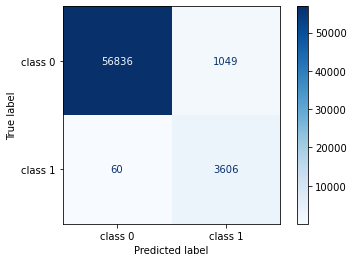

In [37]:
#performance results
print(classification_report(y_test, y_pred1, target_names=target_names))
plot_confusion_matrix(model1, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

  ## Over-sampling with SMOTE

In [38]:
# load library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit on the trainning dataset
X_smote , y_smote = smote.fit_resample(df_X_train_stand, y_train)

print('Origianl dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(y_smote))

Origianl dataset shape: Counter({0: 231605, 1: 14598})
Resample dataset shape: Counter({0: 231605, 1: 231605})


 ### b) Logistic Regression with Synthetic minority over-sampling technique (LR+SMOTE)

In [39]:
#Run grid search only on training set using cross-validation
parameters={'C':np.logspace(-3,3,7), 'penalty':["l1","l2"]}# l1 lasso l2 ridge
model2=GridSearchCV(LogisticRegression(solver='saga' ,max_iter=1000),parameters,cv=5, verbose=3)
model2.fit(X_smote,y_smote)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ...............C=0.001, penalty=l1;, score=0.989 total time= 2.6min
[CV 2/5] END ...............C=0.001, penalty=l1;, score=0.989 total time= 2.6min
[CV 3/5] END ...............C=0.001, penalty=l1;, score=0.989 total time= 2.6min
[CV 4/5] END ...............C=0.001, penalty=l1;, score=0.990 total time= 2.2min
[CV 5/5] END ...............C=0.001, penalty=l1;, score=0.990 total time= 2.6min
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.990 total time= 2.3min
[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.990 total time= 2.3min
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.989 total time= 2.4min
[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.990 total time= 2.0min
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.990 total time= 2.3min
[CV 1/5] END ................C=0.01, penalty=l1;, score=0.990 total time= 4.7min
[CV 2/5] END ................C=0.01, penalty=l1;

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, solver='saga'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [40]:
print("tuned hpyerparameters :(best parameters) ",model2.best_params_)
print("accuracy :",model2.best_score_)
print('Best Model:',model2.best_estimator_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l1'}
accuracy : 0.9912134884825458
Best Model: LogisticRegression(C=10.0, max_iter=1000, penalty='l1', solver='saga')


In [41]:
y_pred2=model2.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99     57885
     class 1       0.79      0.98      0.88      3666

    accuracy                           0.98     61551
   macro avg       0.89      0.98      0.93     61551
weighted avg       0.99      0.98      0.98     61551



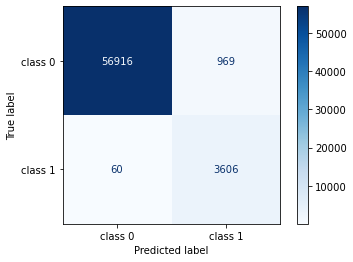

In [42]:
#performance results
print(classification_report(y_test, y_pred2, target_names=target_names))
plot_confusion_matrix(model2, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues); 

### c) Weighted Decision Tree (W-DT)

In [43]:
#Run grid search only on training set using cross-validation
parameters = {'criterion':['gini','entropy'], 'max_depth' : [2,4,6,8,10,12]}
model3 = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), parameters, cv=5, verbose=3)
# fit on the trainning dataset
model3.fit(df_X_train_stand, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .......criterion=gini, max_depth=2;, score=0.966 total time=   0.7s
[CV 2/5] END .......criterion=gini, max_depth=2;, score=0.965 total time=   0.6s
[CV 3/5] END .......criterion=gini, max_depth=2;, score=0.966 total time=   0.7s
[CV 4/5] END .......criterion=gini, max_depth=2;, score=0.964 total time=   0.6s
[CV 5/5] END .......criterion=gini, max_depth=2;, score=0.964 total time=   0.6s
[CV 1/5] END .......criterion=gini, max_depth=4;, score=0.983 total time=   1.3s
[CV 2/5] END .......criterion=gini, max_depth=4;, score=0.983 total time=   1.3s
[CV 3/5] END .......criterion=gini, max_depth=4;, score=0.983 total time=   1.3s
[CV 4/5] END .......criterion=gini, max_depth=4;, score=0.982 total time=   1.3s
[CV 5/5] END .......criterion=gini, max_depth=4;, score=0.982 total time=   1.3s
[CV 1/5] END .......criterion=gini, max_depth=6;, score=0.986 total time=   1.6s
[CV 2/5] END .......criterion=gini, max_depth=6;

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             verbose=3)

In [44]:
print("tuned hpyerparameters :(best parameters) ",model3.best_params_)
print("accuracy :",model3.best_score_)
print('Best Model:',model3.best_estimator_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 12}
accuracy : 0.9998253475573998
Best Model: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12)


In [45]:
y_pred3 = model3.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     57885
     class 1       1.00      1.00      1.00      3666

    accuracy                           1.00     61551
   macro avg       1.00      1.00      1.00     61551
weighted avg       1.00      1.00      1.00     61551



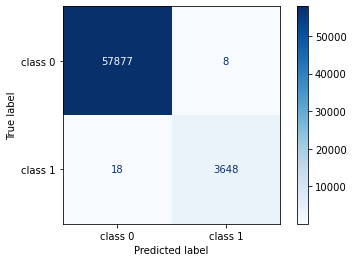

In [46]:
#performance results
print(classification_report(y_test, y_pred3, target_names=target_names))
plot_confusion_matrix(model3, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

## Undersampling using OSS
OneSidedSelection (OSS) is an undersampling technique that combines Tomek Links and the Condensed Nearest Neighbor (CNN) Rule. 

In [47]:
# Import library
from imblearn.under_sampling import OneSidedSelection

In [48]:
# define the undersampling method
oss = OneSidedSelection(random_state=0)
# fit on the trainning dataset
X_oss, y_oss = oss.fit_resample(df_X_train_stand, y_train)
# summarize the new class distribution
counter = Counter(y_oss)
print(counter)

Counter({0: 229131, 1: 14598})


### d) Weighted Support Vector Machine with One Sided Selection (SVM+OSS)

In [50]:
#Run grid search only on training set using cross-validation
parameters = {'C':[1, 5, 10] }
model4 = GridSearchCV(SVC(class_weight='balanced', kernel='rbf'), parameters, cv=5, verbose=3)
model4.fit(X_oss, y_oss)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...............................C=1;, score=0.999 total time= 1.2min
[CV 2/5] END ...............................C=1;, score=0.999 total time= 1.5min
[CV 3/5] END ...............................C=1;, score=0.999 total time= 1.2min
[CV 4/5] END ...............................C=1;, score=0.999 total time= 1.2min
[CV 5/5] END ...............................C=1;, score=0.999 total time= 1.0min
[CV 1/5] END ...............................C=5;, score=1.000 total time=  35.2s
[CV 2/5] END ...............................C=5;, score=0.999 total time=  34.1s
[CV 3/5] END ...............................C=5;, score=1.000 total time=  35.2s
[CV 4/5] END ...............................C=5;, score=0.999 total time=  35.5s
[CV 5/5] END ...............................C=5;, score=0.999 total time=  35.9s
[CV 1/5] END ..............................C=10;, score=1.000 total time=  33.5s
[CV 2/5] END ..............................C=10;,

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1, 5, 10]}, verbose=3)

In [51]:
print("tuned hpyerparameters :(best parameters) ",model4.best_params_)
print("accuracy :",model4.best_score_)
print('Best Model:',model4.best_estimator_)

tuned hpyerparameters :(best parameters)  {'C': 10}
accuracy : 0.9995527820505747
Best Model: SVC(C=10, class_weight='balanced')


In [52]:
y_pred4 = model4.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     57885
     class 1       1.00      1.00      1.00      3666

    accuracy                           1.00     61551
   macro avg       1.00      1.00      1.00     61551
weighted avg       1.00      1.00      1.00     61551



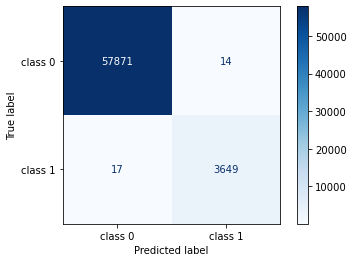

In [53]:
#performance results
print(classification_report(y_test, y_pred4, target_names=target_names))
plot_confusion_matrix(model4, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

### e)  XG Boost, Extreme Gradient Boosting (XGB)

In [55]:
#Run grid search only on training set using cross-validation
parameters = {'max_depth': [5, 10],'n_estimators': [100, 150], 'learning_rate': [0.1, 0.2]}
model5 = GridSearchCV(XGBClassifier(eval_metric='logloss',use_label_encoder =False), parameters, cv=5, verbose=3)
model5.fit(df_X_train_stand, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.1s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.1s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.1s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.0s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total time=   5.5s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total time=   5.6s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total time=   5.7s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total time=   5.7s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total tim

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

In [56]:
print("tuned hpyerparameters :(best parameters) ",model5.best_params_)
print("accuracy :",model5.best_score_)
print('Best Model:',model5.best_estimator_)

tuned hpyerparameters :(best parameters)  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}
accuracy : 0.9999553213722571
Best Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=32,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


In [57]:
y_pred5 = model5.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     57885
     class 1       1.00      0.99      1.00      3666

    accuracy                           1.00     61551
   macro avg       1.00      1.00      1.00     61551
weighted avg       1.00      1.00      1.00     61551



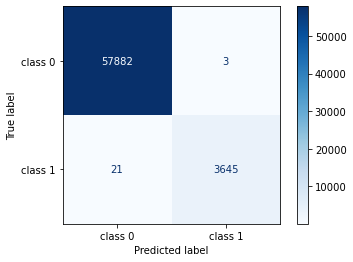

In [58]:
#performance results
print(classification_report(y_test, y_pred5, target_names=target_names))
plot_confusion_matrix(model5, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

In [59]:
#save notebook session
import dill
dill.dump_session('session_esc-01.db')
#to restore a notebook session
#dill.load_session('session_esc-01.db')